In [1]:
# autoload the package, for debuge purpose
%load_ext autoreload
%autoreload 2

# set the display properties
%matplotlib inline

# import modules and plot setting
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import datetime
from astropy.table import Table
from astropy.io import fits
from mangatools import maps, utils

today = datetime.date.today().isoformat()

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

# customize the warning message
import warnings
warnings.filterwarnings("ignore") # default or ignore
from astropy import log
log.setLevel('ERROR')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data relese: MPL-8, configure: mangatools/config.py
Global SAS directory is /Volumes/Lacie2/SAS


# Spectrum Fitting Demonstration

## Testting for a single galaxy

In [12]:
# single test

from mangatools.voronoi_2d_binning import voronoi_2d_binning
from mangatools.maps import Maps
from mangatools.datacube import Datacube
#warnings.filterwarnings("ignore")

plateifu = '9090-3701'
m = Maps(plateifu)
dc = Datacube(plateifu)

In [13]:
sp = dc[21, 21]
pp = sp.ppxf_fit(mode='emline', broad_O3=600, broad_balmer=800)

Emission lines included in gas templates:
['H10' 'H9' 'H8' 'Hepsilon' 'Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[OII]3726'
 '[OII]3729' '[SII]6716' '[SII]6731' '[OIII]4960' '[OIII]5008' '[OI]6302'
 '[OI]6365' '[NII]6549' '[NII]6585' 'NeIII' '[OIII]4364' '[NII]5756'
 '_Hbeta' '_Halpha' '_[OIII]4960' '_[OIII]5008']
Best Fit:       Vel     sigma
 comp. 0:     13577       137
 comp. 1:     13512       168
 comp. 2:     13718      1184
 comp. 3:     13090       600
chi2/DOF: 4.461
method = capfit; Jac calls: 6; Func calls: 58; Status: 2
Nonzero Templates: 24 / 25
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 0           H10     0.1205     0.048   13577   137
Comp: 0            H9          0     0.047   13577   137
Comp: 0            H8      0.231     0.046   13577   137
Comp: 0      Hepsilon     0.1601     0.038   13577   137
Comp: 0        Hdelta     0.1729     0.0

In [14]:
wave_mask = (sp.wave >= pp.lam[0]) & (sp.wave <= pp.lam[-1])

comp0_select = np.where(pp.component == 0)
comp0 = pp.matrix[:, comp0_select] @ (pp.weights[comp0_select] * pp.flux_scale)

comp1_select = np.where(pp.component == 1)
comp1 = pp.matrix[:, comp1_select] @ (pp.weights[comp1_select] * pp.flux_scale)

comp2_select = np.where(pp.component == 2)
comp2 = pp.matrix[:, comp2_select] @ (pp.weights[comp2_select] * pp.flux_scale)

comp3_select = np.where(pp.component == 3)
comp3 = pp.matrix[:, comp3_select] @ (pp.weights[comp3_select] * pp.flux_scale)

In [5]:
pp.galaxy

array([-0.02268434, -0.0302611 ,  0.07151766, ...,  0.00166497,
       -0.02657636, -0.01718738], dtype=float32)

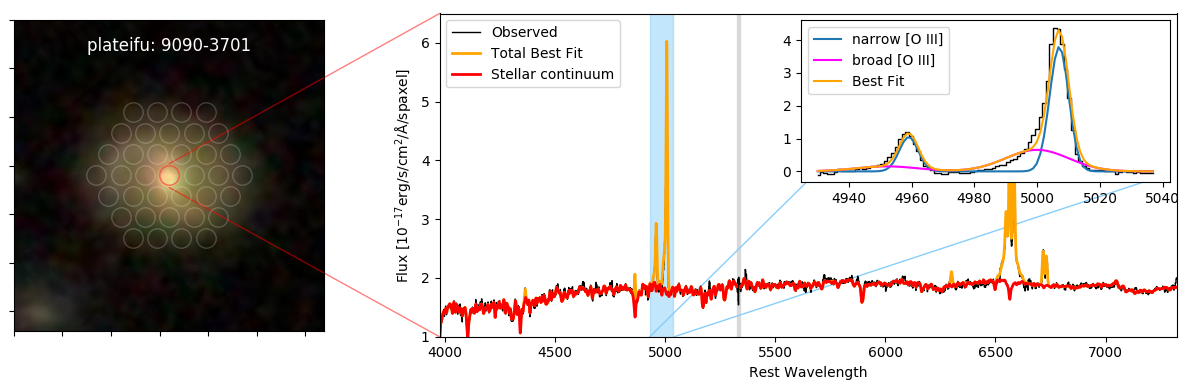

In [16]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch

#plt.style.use('dark_background')
plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
#ax3 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)

#ax1 = fig.add_subplot(141)
#ax2 = fig.add_subplot(122)

#m.image(ax=ax1, showImage=False)
m.image_quary(ax=ax1, scale=0.05, width=640, height=640, show_bundle=False, lw=1, opt='', fs=12,
              show_fibers=True, highlight=0)
ax2.step(sp.wave_rest, sp.flux, label='Observed', where='mid', color='k', lw=1, alpha=1)
ax2.plot(pp.lam/(1+m.z), pp.bestfit*pp.flux_scale + sp.stellarcontinuum[wave_mask], label='Total Best Fit', 
         color='orange', lw=2, alpha=1)
ax2.plot(sp.wave_rest, sp.stellarcontinuum, label='Stellar continuum', color='red', lw=2)
ax2.fill_betweenx([-100, 100], 4930, 5037, color='lightskyblue', alpha=0.5)
ax2.fill_betweenx([-100, 100], 5325, 5340, color='lightgray', alpha=0.8)
ax2.set_xlabel('Rest Wavelength')
ax2.set_ylabel(r'${\rm Flux\ [10^{-17}erg/s/cm^2/\AA/spaxel]}$')
ax2.set_ylim(1., 6.5)
ax2.set_xlim(3800*(1+m.z), 7000*(1+m.z))
ax2.legend(loc=2)

inset_axes = inset_axes(ax2, width="50%", height='50%', loc=1)
lam = pp.lam / (1+m.z)
O3_mask = (lam >=4930) & (lam <= 5037)
inset_axes.step(lam[O3_mask], pp.galaxy[O3_mask]*pp.flux_scale, where='mid', color='k', lw=1, alpha=1)
inset_axes.plot(lam[O3_mask], comp1[O3_mask], label='narrow [O III]', color='C0')
inset_axes.plot(lam[O3_mask], comp3[O3_mask], label='broad [O III]', color='magenta')
inset_axes.plot(lam[O3_mask], pp.bestfit[O3_mask]*pp.flux_scale, label='Best Fit', color='orange')
inset_axes.legend()


xyA1 = (320., 345.)
xyB1 = (3800*(1+m.z), 1.)
con1 = ConnectionPatch(xyA=xyA1, xyB=xyB1, coordsA="data", coordsB="data",
                      axesA=ax1, axesB=ax2, color='red', alpha=0.5)
ax1.add_artist(con1)
xyA2 = (320., 296.)
xyB2 = (3800*(1+m.z), 6.5)
con2 = ConnectionPatch(xyA=xyA2, xyB=xyB2, coordsA="data", coordsB="data",
                      axesA=ax1, axesB=ax2, color='red', alpha=0.5)
ax1.add_artist(con2)
# connecting plot with inset_axes
xyB3 = (4930, 1.)
xyC3 = (4930., 0.)
con3 = ConnectionPatch(xyA=xyB3, xyB=xyC3, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=inset_axes, color='lightskyblue', alpha=1)
ax2.add_artist(con3)
xyB4 = (5041, 1.)
xyC4 = (5041., -0.1)
con4 = ConnectionPatch(xyA=xyB4, xyB=xyC4, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=inset_axes, color='lightskyblue', alpha=1)
ax2.add_artist(con4)
#fig.savefig('./results/spectrum_fitting.pdf', bbox_inches='tight')
plt.tight_layout()

In [ ]:
mask = ~(agn | cp | sf)
#mask = ~agn
#mask = np.ones_like(agn)
#mask[26:29, 26:29] = 0
dc = Datacube(plateifu)
dc.flux_map(plateifu+'test', mask=mask, directory='/tmp', quiet=1, auto=True, save_maps=True, save_cube=True)

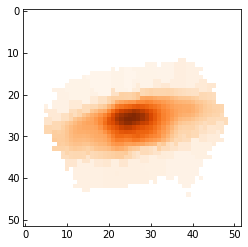

In [5]:
plt.imshow(dc.flux[1000, :, :])

In [29]:
# reading the fitted cubes
hdu = fits.open('/tmp/{}test-cubes.fits'.format(plateifu))
hdu.info()

Filename: /tmp/8720-1901test-cubes.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  WAVE          1 ImageHDU         7   (4563,)   float32   
  2  EMLINE        1 ImageHDU         9   (34, 34, 4563)   float32   
  3  FITS          1 ImageHDU        10   (3, 34, 34, 4563)   float64   


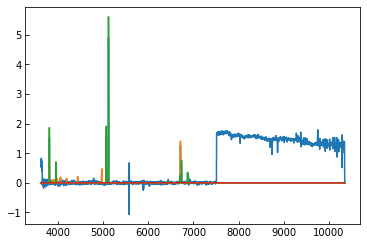

In [30]:
# visualize the fitting results of one pixel
wave = hdu['wave'].data
emlines = hdu['emline'].data
emfits = hdu['fits'].data

plt.plot(wave, emlines[:, 17, 17])
plt.plot(wave, emfits[:, 17, 17, 0])
plt.plot(wave, emfits[:, 17, 17, 1])
plt.plot(wave, emfits[:, 17, 17, 2])

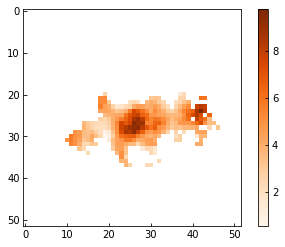

In [10]:
# reading the fitted maps
from astropy.io import fits
with fits.open('/tmp/{}test.fits'.format(plateifu)) as f:
    #f.info()
    Ha= f['Hbeta'].data[0]
    Ha_err = f['Hbeta'].data[1]
    plt.imshow(Ha/Ha_err)
    plt.colorbar()

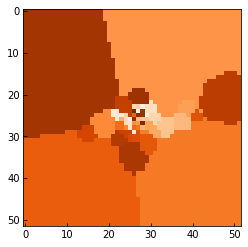

In [12]:
# fitting with spectrum after stacking
with fits.open('/tmp/{}test.fits'.format(plateifu)) as f:
    x_coor, y_coor = m.maps['SPX_SKYCOO'].data
    Hb = f['Hbeta'].data[0]
    Hb_err = f['Hbeta'].data[1]
    binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
                    x_coor.flatten(), y_coor.flatten(), Hb.flatten(), Hb_err.flatten()+1e-8, 
                    10, plot=0, quiet=1)
    #binNum = np.zeros_like(Hb.flatten())
    binNum = binNum.reshape(Hb.shape)
plt.imshow(binNum)
#dc.stack(binNum)
#dc.flux_map(plateifu+'_binned', mask=mask, directory='/tmp', quiet=1, auto=True)

cannot reach global 10 uniform Bin-id was used!


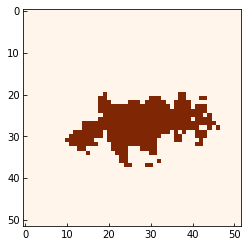

In [13]:
with fits.open('/tmp/{}test.fits'.format(plateifu)) as f:
    x_coor, y_coor = m.maps['SPX_SKYCOO'].data
    Hb = f['Hbeta'].data[0]
    Hb_err = f['Hbeta'].data[1]
    
    binNum = dc.genBinMatrix(Hb, Hb_err, 10, quiet=False)
    #plt.imshow(binNum)
    #dc.stack(binNum)
    #dc.flux_map_new(plateifu+'_binned', mask=None, directory='/tmp', quiet=0, auto=True, save_maps=True, save_cube=False, binmatrix=binNum)
plt.imshow(binNum)

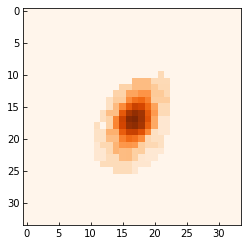

In [6]:
dc.stack(binNum)
plt.imshow(dc.flux[1000, :, :])

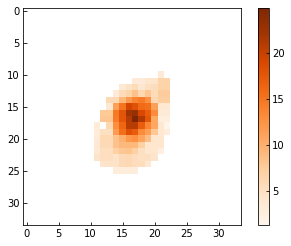

In [16]:
plt.imshow(Hb/Hb_err)
plt.colorbar()

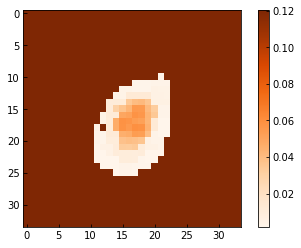

In [11]:
from astropy.io import fits
with fits.open('/tmp/{}_binned-maps.fits'.format(plateifu)) as f:
    #f.info()
    Ha= f['Halpha'].data[1]
    plt.imshow(Ha)
    plt.colorbar()

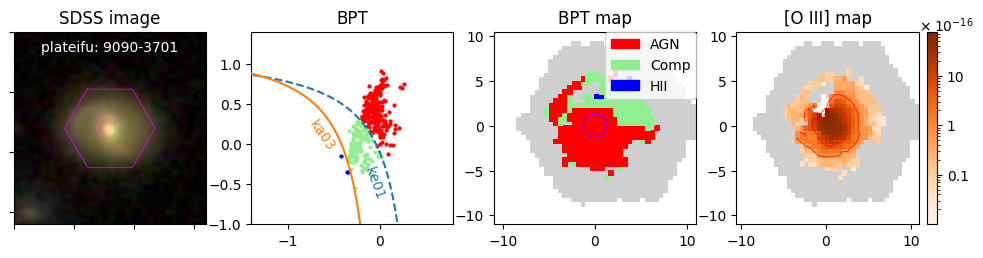

In [36]:
from mangatools.maps import Maps
from mangatools.fitmaps import FitMaps

fm_dir = '/Volumes/Lacie2/fitmaps/fitmap/' #set to your local folder
fm_binned_dir = '/Volumes/Lacie2/fitmaps/fitmap2/' #set to your local folder

fig = plt.figure(figsize=(12, 2.5))
#plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1, wspace=0.4, hspace=0.14)
ax = fig.subplots(1, 4)
fs = 10

if True:
    plateifu = '9090-3701'
    try:
        m = Maps(plateifu)
        fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)        
        agn, cp, sf, *others = m.bptregion()
    except:
        print('Escape plateifu:{}'.format(plateifu))
    m.image_quary(ax=ax[0], scale=0.05, width=640, height=640, show_bundle=True, lw=0.5, opt='', fs=fs)
    m.bpt(ax=ax[1], showImage=False, mini=True, fs=fs)
    ax[1].text(-0.2, -0.4, 'ke01', rotation=-70, fontsize=fs, color='C0')
    ax[1].text(-0.8, 0.2, 'ka03', rotation=-55, fontsize=fs, color='C1')

    m.bpt2d(ax=ax[2], show_psf=True, showImage=False, mini=True, fs=fs, show_bundle=True)
    
    O3_corr, O3_corr_err = fm.O3map(fix_outlier=True, smooth=False)
    x, y = m.maps['SPX_SKYCOO'].data
    x = np.flip(x)
    extent = [x.min(), x.max(), y.min(), y.max()]
    
    sb = 4 * O3_corr / 10
    im = ax[3].pcolormesh(x, y, sb, norm=colors.LogNorm(vmin=0.01, vmax=sb.max()), cmap='Oranges')
    cs = ax[3].contour(x, y, sb, levels=[1, 10], colors='r', extent=extent, linewidths=0.5)
    plt.clabel(cs, inline=1, fontsize=5, fmt='%1.1f')
    cbar = plt.colorbar(im, ax=ax[3], fraction=0.056, pad=0.04, ticks=[0.1, 1, 10], 
                        orientation='vertical')
    cbar.ax.tick_params(labelsize=fs)
    cbar.ax.set_title(r'$\quad\quad\times 10^{-16}$', fontsize=fs, pad=0.2)
    ax[3].tick_params(axis='both', which='major', labelsize=fs)
    m.bundle_edge(ax[3])
    cbar.ax.set_yticklabels(['0.1', '1', '10'])  # horizontal colorbar
    
    ax[0].set_title('SDSS image', fontsize=fs+2)
    ax[1].set_title("BPT", fontsize=fs+2)
    ax[2].set_title('BPT map', fontsize=fs+2)
    ax[3].set_title('[O III] map', fontsize=fs+2)

## Testting for parrallel

In [103]:
from multiprocessing import Pool

test_sample = ['7815-6104', '7991-6104', '8132-6101', '8247-6101']

def ptest(plateifu):
    m = Maps(plateifu)
    agn, cp, sf, *others = m.bptregion()
    mask = ~(agn | cp | sf)
    #mask = ~agn
    #mask = np.ones_like(agn)
    #mask[23, 23] = 0
    dc = Datacube(plateifu)
    dc.flux_map(plateifu, mask=mask, directory='/tmp', quiet=1, auto=True)
    print("{} is done".format(plateifu))

with Pool(4) as p:
    p.map(ptest, test_sample)

7991-6104 is done
8132-6101 is done
8247-6101 is done
7815-6104 is done


In [ ]:
from multiprocessing import Pool
from mangatools.voronoi_2d_binning import voronoi_2d_binning
from mangatools.maps import Maps
from mangatools.datacube import Datacube
#warnings.filterwarnings(\"ignore\")

#fitmaps_dir = '/Volumes/DATA/fitmap/'
#fitmaps_binned_dir = '/Volumes/DATA/fitmap3/'
fitmaps_dir = '/tmp/fitmap/' #changing to other local folder to store the results
fitmaps_binned_dir = '/tmp/fitmap2/'

targets = ['8241-6102', '8720-1901', '8547-12701', '8978-12705','8978-6102','10217-12704',
           '10221-6104', '9503-12701','10510-12704']

def pfitmap2(plateifu):
    m = Maps(plateifu)
    agn, cp, sf, *others = m.bptregion()
    mask = ~(agn | cp | sf)
    dc = Datacube(plateifu)
    #dc.flux_map(plateifu, mask=mask, directory=fitmaps_dir, quiet=1, auto=True, save_maps=True, save_cube=True)
    
    with fits.open('{}{}.fits'.format(fitmaps_dir, plateifu)) as f:
        x_coor, y_coor = m.maps['SPX_SKYCOO'].data
        Hb = f['Hbeta'].data[0]
        Hb_err = f['Hbeta'].data[1]
   
        binNum = dc.genBinMatrix(Hb, Hb_err, 10, quiet=True, mask=mask)
    #plt.imshow(binNum)
    if binNum is None:
        print("No need to bin {}".format(plateifu))
    else:
        dc.stack(binNum)
        dc.flux_map_new(plateifu+'_binned', mask=mask, directory=fitmaps_binned_dir, quiet=1, auto=True, save_maps=True, save_cube=False, binmatrix=binNum)
    print(plateifu)
#plt.imshow(binNum)

with Pool(5) as p:
    p.map(pfitmap2, targets)


No need to bin 8241-6102
8241-6102
8978-6102


In [ ]:
from astropy.io import fits
plateifu = '10217-12704'
with fits.open('/Volumes/DATA/fitmap/{}.fits'.format(plateifu)) as f:
    #f.info()
    Hb= f['Hbeta'].data[0]
    Hb_err = f['Hbeta'].data[1]
    plt.imshow(Hb/Hb_err)
    plt.colorbar()

In [13]:
# checking binning process
from mangatools.maps import Maps
from mangatools.datacube import Datacube

m = Maps(plateifu)
agn, cp, sf, *others = m.bptregion()
mask = ~(agn | cp | sf)
dc = Datacube(plateifu)
binNum = dc.genBinMatrix(Hb, Hb_err, 10, quiet=False)
plt.imshow(binNum)

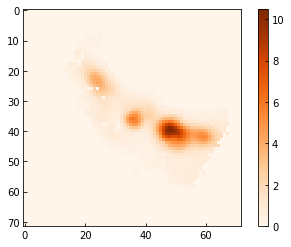

In [17]:
# checking the fitting results
from astropy.io import fits
with fits.open('/Volumes/DATA/fitmap/{}.fits'.format(plateifu)) as f:
    #f.info()
    Ha= f['Hbeta'].data[0]
    #Ha_err = f['Hbeta'].data[1]
    plt.imshow(Ha)
    plt.colorbar()

## Statistics

In [2]:
# for linux machine

from multiprocessing import Pool
from mangatools.voronoi_2d_binning import voronoi_2d_binning
from mangatools.maps import Maps
from mangatools.datacube import Datacube
#warnings.filterwarnings("ignore")

fitmaps_dir = '/Volumes/Lacie2/fitmaps/fitmap_S2'

targets = ['8158-3704', '9031-12704', '7972-3704', '9193-6102', '8937-1901', '10217-12704', '9889-1902']

def pfitmap(plateifu):
    m = Maps(plateifu)
    agn, cp, sf, *others = m.bptregion()
    mask = ~(agn | cp | sf)
    dc = Datacube(plateifu)
    dc.flux_map(plateifu, mask=mask, directory=fitmaps_dir, quiet=1, auto=True, save_maps=True, save_cube=False)

with Pool(4) as p:
    p.map(pfitmap, targets)

In [ ]:
# Fitting all the datacubes of DR15

fitmaps_dir = '/Volumes/Lacie2/ENLR/fitmaps' #set to your local folder
fitmaps_binned_dir = '/Volumes/Lacie2/ENLR/fitmaps_binned' #set to your local folder

from vorbin.voronoi_2d_binning import voronoi_2d_binning
#warnings.filterwarnings("ignore")

targets = Table.read('data/AGNs-2019-03-20.dat', format='ascii')

for idx, plateifu in enumerate(targets['plateifu']):
    print(idx, plateifu)
    m = galaxy.Maps(plateifu)
    agn, cp, sf, *others = m.bptregion()
    mask = agn | cp | sf
    #mask = np.ones_like(agn)
    #mask[23, 23] = 0
    dc = galaxy.Datacube(plateifu)
    dc.flux_map(plateifu, mask=~mask, directory=fitmaps_dir, quiet=1, auto=True)

    with fits.open(fitmaps_dir+'{}.fits'.format(plateifu)) as f:
        Hb = f['Hbeta'].data[0]
        Hb_err = f['Hbeta'].data[1]
        binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
                        m.ra_map.flatten(), m.dec_map.flatten(), Hb.flatten(), Hb_err.flatten()+1e-8, 
                        10, plot=0, quiet=1)
        #binNum = np.zeros_like(Hb.flatten())
        binNum = binNum.reshape(Hb.shape)

    dc.stack(binNum)
    dc.flux_map(plateifu, mask=~mask, directory=fitmaps_binned_dir, quiet=1, auto=True)

## Demo-Sample-Detail

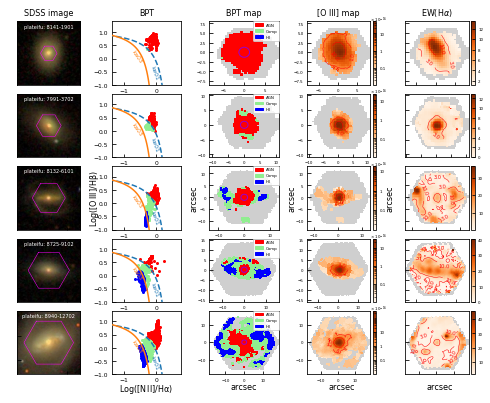

In [233]:
# Demo + Paper, pick some example for illustration of the paper
# History: 
#  2018-10-04: add history
#  2019-01-14: 

from mangatools.maps import Maps
from mangatools.fitmaps import FitMaps
import matplotlib.colors as colors

#fm_dir = '/Volumes/Lacie2/ENLR/fitmaps/' #set to your local folder
#fm_binned_dir = '/Volumes/Lacie2/ENLR/fitmaps_binned/' #set to your local folder

fm_dir = '/Volumes/Lacie2/fitmaps/fitmap/' #set to your local folder
fm_binned_dir = '/Volumes/Lacie2/fitmaps/fitmap2/' #set to your local folder

targets = ['8141-1901', '7991-3702', '8132-6101', '8725-9102', '8940-12702']

fig = plt.figure(figsize=(8, 7))
ax0 = fig.subplots(1, 5)
for i in range(5):
    ax0[i].spines['top'].set_color('none')
    ax0[i].spines['bottom'].set_color('none')
    ax0[i].spines['left'].set_color('none')
    ax0[i].spines['right'].set_color('none')
    ax0[i].tick_params(axis='both', labelcolor='w', top='off', bottom='off', left='off', right='off', labelsize=2)

ax = fig.subplots(5, 5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.1, wspace=0.4, hspace=0.14)

for i in range(len(targets)):
    plateifu = targets[i]
    try:
        m = Maps(plateifu)
        fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
        
        agn, cp, sf, *others = m.bptregion()

#plt.imshow(m2.E_BV, origin='lower')
    except:
        print('Escape plateifu:{}'.format(plateifu))
        continue
    #width = int(m.ifudsgn) // 10
    #m.image(ax=ax[i, 0], showImage=False, mini=True, fs=5)
    m.image_quary(ax=ax[i, 0], scale=0.06, width=640, height=640, show_bundle=True, lw=0.5, opt='', fs=5)
    m.bpt(ax=ax[i, 1], showImage=False, mini=True, fs=6)
    ax[i,1].text(-0.2, -0.4, 'ke01', rotation=-70, fontsize=6, color='C0')
    ax[i,1].text(-0.8, 0.2, 'ka03', rotation=-55, fontsize=6, color='C1')

    m.bpt2d(ax=ax[i, 2], show_psf=True, showImage=False, mini=True, fs=4, show_bundle=True)
    #ax[i, 2].text(-5, 5, '19', fontsize=fs)
    #m.vfield(ax=ax[i, 2], showImage=False, mini=True, fs=2)
    #m.line('OIII-5008', plot=True, ax=ax[i, 3], showImage=False, redcorr=True, snr=3,
    #       mini=True, fs=4, showColorbar=False)
    #m.line_ew('Ha-6564', plot=True, ax=ax[i, 4], showImage=False, mini=True, fs=4, showColorbar=False)
    
    O3_corr, O3_corr_err = fm.O3map(fix_outlier=True, smooth=False)

    #m.redcorrmap(plot=True, showImage=False, ax=ax[i,4], mini=True, fs=4, showColorbar=True)
    x, y = m.maps['SPX_SKYCOO'].data
    x = np.flip(x)
    extent = [x.min(), x.max(), y.min(), y.max()]
    
    sb = 4 * O3_corr / 10
    im = ax[i, 3].pcolormesh(x, y, sb, norm=colors.LogNorm(vmin=0.01, vmax=sb.max()), cmap='Oranges')
    cs = ax[i, 3].contour(x, y, sb, levels=[1, 10], colors='r', extent=extent, linewidths=0.5)
    plt.clabel(cs, inline=1, fontsize=5, fmt='%1.1f')
    cbar = plt.colorbar(im, ax=ax[i, 3], fraction=0.056, pad=0.04, ticks=[0.1, 1, 10], 
                        orientation='vertical')
    cbar.ax.tick_params(labelsize=4)
    cbar.ax.set_title(r'$\quad\quad\times 10^{-16}$', fontsize=4, pad=0.2)
    ax[i, 3].tick_params(axis='both', which='major', labelsize=4)
    m.bundle_edge(ax[i, 3])
    # change the tick label
    #cbar = fig.colorbar(cax, ticks=[0.1, 1, 10], orientation='horizontal')
    cbar.ax.set_yticklabels(['0.1', '1', '10'])  # horizontal colorbar
    #labels = [item.get_text() for item in cbar.get_xticklabels()]
    #labels[1] = 'Testing'
    #cbar.set_xticklabels(labels)

    m.line_ew('Ha-6564', plot=True, ax=ax[i, 4], showImage=False, mini=True, fs=4, showColorbar=True)
    # show for E(B-V)
    #E_BV = np.ma.array(fm.E_BV, mask=~(agn | cp | sf))
    #im = ax[i, 4].pcolormesh(x, y, E_BV, vmax=0.6, cmap='Oranges')
    #cbar = plt.colorbar(im, ax=ax[i, 4], fraction=0.056, pad=0.04)
    #cbar.ax.tick_params(labelsize=4)
    ax[i, 4].tick_params(axis='both', which='major', labelsize=4)
    m.bundle_edge(ax[i, 4])


ax[0, 0].set_title('SDSS image', fontsize=8)
ax[0, 1].set_title("BPT", fontsize=8)
ax[0, 2].set_title('BPT map', fontsize=8)
ax[0, 3].set_title('[O III] map', fontsize=8)
ax[0, 4].set_title(r"EW(H$\alpha$)", fontsize=8)

ax0[1].set_ylabel(r'${\rm Log([O\,III]/H\beta)}$', fontsize=8)
ax0[1].set_xlabel(r'${\rm Log([N\,II]/H\alpha)}$', fontsize=8)
ax0[2].set_xlabel('arcsec', fontsize=8)
ax0[2].set_ylabel('arcsec', fontsize=8)
ax0[3].set_xlabel('arcsec', fontsize=8)
ax0[3].set_ylabel('arcsec', fontsize=8)
ax0[4].set_xlabel('arcsec', fontsize=8)
ax0[4].set_ylabel('arcsec', fontsize=8)


plt.show()
#plt.tight_layout()
fig.savefig("./results/detail_sample.pdf", bbox_inches='tight')

# [O III] Luminosity
Calculating the luminosity of [O III]5007Å and saving into data/LO3.dat

In [210]:
# Measuring L[OIII5007], using fitting [O III] map
#
# History:
#   2018-08-24: first release
#   2018-09-06: update the error calculation
#   2019-01-12: using new OIII data
#   2019-06-16: run for the paper first submission
#   2019-06-25: add the option for EW(Ha)>3A of agn region

from mangatools.maps import Maps
from mangatools.fitmaps import FitMaps

useHaEW = True

fm_dir = '/Volumes/Lacie2/fitmaps/fitmap/' #set to your local folder
fm_binned_dir = '/Volumes/Lacie2/fitmaps/fitmap2/' #set to your local folder

warnings.filterwarnings("ignore")
targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')

with open('data/LO3-{}.dat'.format(today), 'w') as f:
    f.write("# AGNs_file: data/AGNs-2018-04-26.dat\n")
    f.write("# Using datacube fitting map to calculate the L[O III] 5007\n")
    f.write("{} {} {} {} {} {} {} {} {}\n".format("plateifu", "LO3", "LO3_err_low", 
                                               "LO3_err_up","LO3_redcorr", "LO3_redcorr_err_low", 
                                               "LO3_redcorr_err_up", "outflow_strength", 
                                               "outflow_strength_err"))
    tot_num = len(targets[:])
    for i in range(tot_num):
        plateifu = targets['plateifu'][i]
        m = Maps(plateifu)
        
        agn, cp, *others = m.bptregion()
        if useHaEW:
            HaEW_region = m.line_ew('Ha-6564') > 3
            agn = agn & HaEW_region

        #m2 = Maps2(plateifu)
        try:
            fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
            O3_narrow, O3_narrow_err = fm.line('[OIII]5008')[0], fm.line('[OIII]5008')[1]
            O3_broad, O3_broad_err = fm.line('_[OIII]5008')[0], fm.line('_[OIII]5008')[1]
            O3_corr, O3_corr_err = fm.O3map()
        
        except:
            print(plateifu)
            f.write("{} {} {} {} {} {} {} {} {}\n".format(plateifu, 1e-6, 1e-6, 1e-6, 
                                                   1e-6, 1e-6, 1e-6, 1e-6, 0))
            continue
        
      
        O3_narrow_sum, O3_narrow_sum_err = np.sum(O3_narrow[agn]), np.sqrt(np.sum(O3_narrow_err[agn]**2))
        O3_broad_sum, O3_broad_sum_err = np.sum(O3_broad[agn]), np.sqrt(np.sum(O3_broad_err[agn]**2))
        outflow_strength = O3_broad_sum / (O3_narrow_sum + O3_broad_sum)
        outflow_strength_err = np.sqrt((O3_broad_sum_err/O3_narrow_sum)**2 +
                                       (O3_narrow_sum_err/O3_narrow_sum**2*O3_broad_sum)**2)
        
        O3_agn = np.sum(O3_narrow[agn] + O3_broad[agn])
        O3_agn_up = np.sum(O3_narrow[agn|cp] + O3_broad[agn|cp])
        O3_agn_err = np.sqrt(np.sum(O3_narrow_err[agn]**2 + O3_broad_err[agn]**2))
        O3_agn_err_up = np.sqrt(np.sum(O3_narrow_err[agn|cp]**2 + O3_broad_err[agn|cp]**2))
    
        O3_agn_corr = np.sum(O3_corr[agn])
        O3_agn_corr_up = np.sum(O3_corr[agn|cp])
        O3_agn_corr_err = np.sum(np.sqrt(O3_corr_err[agn]**2))
        O3_agn_corr_err_up = np.sum(np.sqrt(O3_corr_err[agn|cp]**2))
        
        LO3 = np.log10(O3_agn*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))
        #LO3_err_low = np.log10(O3_agn_err*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))/np.log(10)/LO3
        LO3_err_low = O3_agn_err/np.log(10)/O3_agn
        #LO3_err_up = np.log10(O3_agn_err_up*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))/np.log(10)/LO3
        LO3_err_up = O3_agn_err_up/np.log(10)/O3_agn
        LO3_redcorr = np.log10(O3_agn_corr*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))
        #LO3_redcorr_err_low = np.log10(O3_agn_corr_err*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))/np.log(10)/LO3_redcorr
        LO3_redcorr_err_low = O3_agn_corr_err/np.log(10)/O3_agn_corr
        #LO3_redcorr_err_up = np.log10(O3_agn_corr_err_up*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))/np.log(10)/LO3_redcorr
        LO3_redcorr_err_up = O3_agn_corr_err_up/np.log(10)/O3_agn_corr_err
        f.write("{} {} {} {} {} {} {} {} {}\n".format(plateifu, LO3, LO3_err_low, LO3_err_up, 
                                                   LO3_redcorr, LO3_redcorr_err_low,
                                                   LO3_redcorr_err_up, outflow_strength,
                                                   outflow_strength_err))
        utils.processBar(tot_num-1, i)
    print('Done! Write into {}'.format(f.name))

[########################################] 100% 
Done! Write into data/LO3-2019-06-26.dat


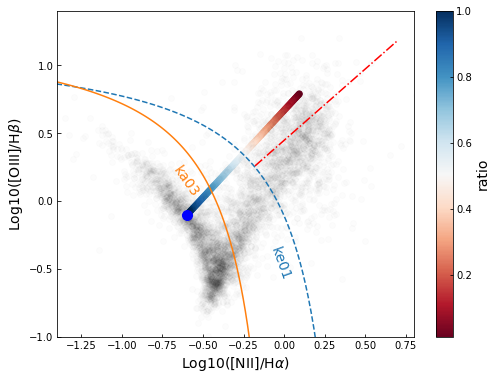

In [93]:
# follow Kauffmann & Heckmann 2009 to quantify the sf contribution

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

f_agn = Table.read('./data/AGNs-2019-04-26.dat', format='ascii')
f_exclude = Table.read('./data/AGNs-exclude-2019-04-26.dat', format='ascii')
subfig1 = ax.plot(f_exclude['BPT_x'], f_exclude['BPT_y'], 'ko', alpha=0.01)
subfig2 = ax.plot(f_agn['BPT_x'], f_agn['BPT_y'], 'ko', alpha=0.01)

# plot the line
x1 = np.linspace(-1.5, 0.2, 100)
ke01 = 0.61/(x1-0.47)+1.19
x2 = np.linspace(-1.5, -.2, 100)
ka03 = 0.61/(x2-0.05)+1.3
x3 = np.linspace(-0.18, 0.7, 100)
schawinski_line = 1.05*x3+0.45
ax.plot(x1, ke01, '--', color='C0') 
ax.text(-0.7, 0.2, 'ka03', rotation=-55, fontsize=14, color='C1')
ax.plot(x2, ka03, 'C1') 
ax.text(-0.1, -0.4, 'ke01', rotation=-70, fontsize=14, color='C0')
ax.plot(x3, schawinski_line, 'r-.')

# demonstrate the different contribution
ax.plot(-0.6, -0.1, 'bo', ms=10)
#ax.plot(0.1, 0.8, 'ro')

rho = np.linspace(0.01, 1, 100) #the fraction of SF
comp_x = rho*(-0.6) + (1-rho)*0.1
comp_y = rho*(-0.1) + (1-rho)*0.8
subfig = ax.scatter(comp_x, comp_y, c=rho, cmap='RdBu')
cbar = fig.colorbar(subfig)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('ratio', fontsize=14)

ax.set_xlim((-1.4, 0.8))
ax.set_ylim((-1., 1.4))
ax.set_xlabel(r'Log10([NII]/H$\alpha)$', fontsize=14)
ax.set_ylabel(r'Log10([OIII]/H$\beta)$', fontsize=14)

fig.savefig('./results/response1-1.pdf', bbox_inches='tight')

In [70]:
# Measuring L[OIII5007], using fitting [O III] map
# The contribution from star forming regio is follow the same method from Kauffmann & Heckman 2009
#
# History:
#   2019-06-16: first release

from mangatools.maps import Maps
from mangatools.fitmaps import FitMaps

fm_dir = '/Volumes/Lacie2/fitmaps/fitmap/' #set to your local folder
fm_binned_dir = '/Volumes/Lacie2/fitmaps/fitmap2/' #set to your local folder

warnings.filterwarnings("ignore")
targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')

with open('data/LO3-{}-2.dat'.format(today), 'w') as f:
    f.write("# AGNs_file: data/AGNs-2018-04-26.dat\n")
    f.write("# Using datacube fitting map to calculate the L[O III] 5007\n")
    f.write("{} {} {} {} {} {} {} {} {}\n".format("plateifu", "LO3", "LO3_err_low", 
                                               "LO3_err_up","LO3_redcorr", "LO3_redcorr_err_low", 
                                               "LO3_redcorr_err_up", "outflow_strength", 
                                               "outflow_strength_err"))
    tot_num = len(targets[:])
    for i in range(tot_num):
        plateifu = targets['plateifu'][i]
        m = Maps(plateifu)
        agn, cp, *others = m.bptregion()
        #m2 = Maps2(plateifu)
        try:
            fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
            O3_narrow, O3_narrow_err = fm.line('[OIII]5008')[0], fm.line('[OIII]5008')[1]
            O3_broad, O3_broad_err = fm.line('_[OIII]5008')[0], fm.line('_[OIII]5008')[1]
            O3_corr, O3_corr_err = fm.O3map()
            ratio = np.sqrt((m.bptx+0.6)**2 + (m.bpty+0.1)**2)
            ratio[ratio > 1] = 1
        except:
            print(plateifu)
            f.write("{} {} {} {} {} {} {} {} {}\n".format(plateifu, 1e-6, 1e-6, 1e-6, 
                                                   1e-6, 1e-6, 1e-6, 1e-6, 0))
            continue
        
      
        O3_narrow_sum, O3_narrow_sum_err = np.sum(O3_narrow[agn]), np.sqrt(np.sum(O3_narrow_err[agn]**2))
        O3_broad_sum, O3_broad_sum_err = np.sum(O3_broad[agn]), np.sqrt(np.sum(O3_broad_err[agn]**2))
        outflow_strength = O3_broad_sum / (O3_narrow_sum + O3_broad_sum)
        outflow_strength_err = np.sqrt((O3_broad_sum_err/O3_narrow_sum)**2 +
                                       (O3_narrow_sum_err/O3_narrow_sum**2*O3_broad_sum)**2)
        #outflow_strength = np.sum(O3_broad[agn]) / np.sum(O3_narrow[agn])
        #outflow_strength_err = np.sqrt(np.sum((O3_broad_err[agn]/O3_narrow[agn])**2) 
        #               + np.sum((O3_narrow_err[agn]/(O3_narrow[agn])**2 * O3_broad[agn])**2))
        
        O3_agn = np.sum(O3_narrow[agn] + O3_broad[agn])
        O3_agn_up = np.sum(O3_narrow[agn|cp] + O3_broad[agn|cp])
        O3_agn_err = np.sqrt(np.sum(O3_narrow_err[agn]**2 + O3_broad_err[agn]**2))
        O3_agn_err_up = np.sqrt(np.sum(O3_narrow_err[agn|cp]**2 + O3_broad_err[agn|cp]**2))
    
        O3_agn_corr = np.sum(O3_corr[agn])
        O3_agn_corr_up = np.sum(O3_corr[agn|cp] * ratio[agn|cp])
        O3_agn_corr_err = np.sum(np.sqrt(O3_corr_err[agn]**2))
        O3_agn_corr_err_up = np.sum(np.sqrt(O3_corr_err[agn|cp]**2))
        
        LO3 = np.log10(O3_agn*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))
        #LO3_err_low = np.log10(O3_agn_err*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))/np.log(10)/LO3
        LO3_err_low = O3_agn_err/np.log(10)/O3_agn
        #LO3_err_up = np.log10(O3_agn_err_up*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))/np.log(10)/LO3
        LO3_err_up = O3_agn_err_up/np.log(10)/O3_agn
        LO3_redcorr = np.log10(O3_agn_corr_up*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))
        #LO3_redcorr_err_low = np.log10(O3_agn_corr_err*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))/np.log(10)/LO3_redcorr
        LO3_redcorr_err_low = O3_agn_corr_err/np.log(10)/O3_agn_corr
        #LO3_redcorr_err_up = np.log10(O3_agn_corr_err_up*1e-17/u.cm**2*4*np.pi*(m.d**2).to(u.cm**2))/np.log(10)/LO3_redcorr
        LO3_redcorr_err_up = O3_agn_corr_err_up/np.log(10)/O3_agn_corr_err
        f.write("{} {} {} {} {} {} {} {} {}\n".format(plateifu, LO3, LO3_err_low, LO3_err_up, 
                                                   LO3_redcorr, LO3_redcorr_err_low,
                                                   LO3_redcorr_err_up, outflow_strength,
                                                   outflow_strength_err))
        utils.processBar(tot_num-1, i)
    print('Done! Write into {}'.format(f.name))

[########################################] 100% 
Done! Write into data/LO3-2019-06-16-2.dat


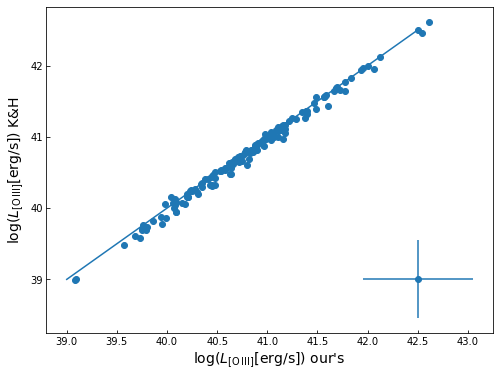

In [94]:
LO3 = Table.read('data/LO3-2019-06-16.dat', format='ascii')
LO3_2 = Table.read('data/LO3-2019-06-16-2.dat', format='ascii')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(LO3['LO3_redcorr'], LO3_2['LO3_redcorr'], 'o', color='C0')
#ax.errorbar(LO3['LO3_redcorr'], LO3_2['LO3_redcorr'], xerr=LO3['LO3_redcorr_err_up'], yerr=LO3_2['LO3_redcorr_err_up'], alpha=0.1, color='C0')
mean_x_err = np.mean(np.ma.array(LO3['LO3_redcorr_err_up'], mask=np.isnan(LO3['LO3_redcorr_err_up'])))
mean_y_err = np.mean(np.ma.array(LO3_2['LO3_redcorr_err_up'], mask=np.isnan(LO3_2['LO3_redcorr_err_up'])))

ax.plot(42.5, 39, 'o', color='C0')
ax.errorbar(42.5, 39, xerr=mean_x_err, yerr=mean_y_err, color='C0')

x0 = np.linspace(39, 42.5, 100)
y0 = x0
ax.plot(x0, y0)
ax.set_xlabel(r"log($L_{\rm [O\,III]}$[erg/s]) our's", fontsize=14)
ax.set_ylabel(r"log($L_{\rm [O\,III]}$[erg/s]) K&H", fontsize=14)

fig.savefig('./results/response1-2.pdf', bbox_inches='tight')

In [ ]:
# Visualize the OIII broad region
#
# History:
#   

from mangatools.maps import Maps
from mangatools.fitmaps import FitMaps
import matplotlib.backends.backend_pdf as mpdf
import matplotlib.colors as colors
from matplotlib.patches import Circle

useHaEW = True
plot=True

fm_dir = '/Volumes/Lacie2/fitmaps/fitmap/' #set to your local folder
fm_binned_dir = '/Volumes/Lacie2/fitmaps/fitmap2/' #set to your local folder

warnings.filterwarnings("ignore")
targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')

with open('data/LO3-{}.dat'.format(today), 'w') as f:
    f.write("# AGNs_file: data/AGNs-2018-04-26.dat\n")
    f.write("# Using datacube fitting map to calculate the L[O III] 5007\n")
    f.write("{} {} {} {} {} {} {} {} {}\n".format("plateifu", "LO3", "LO3_err_low", 
                                               "LO3_err_up","LO3_redcorr", "LO3_redcorr_err_low", 
                                               "LO3_redcorr_err_up", "outflow_strength", 
                                               "outflow_strength_err"))
    if plot: #plot into file
            pdf = mpdf.PdfPages('results/checkmap-OIII-2-{}.pdf'.format(today))
    tot_num = len(targets[:])
    for i in range(tot_num):
        plateifu = targets['plateifu'][i]
        m = Maps(plateifu)
        xx = (np.arange(m.naxis1) - m.naxis1 * 0.5) * 0.5
        yy = (np.arange(m.naxis2) - m.naxis2 * 0.5) * 0.5
        x_coor, y_coor = np.meshgrid(xx, yy)


        try:
            fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
            O3_narrow, O3_narrow_err = fm.line('[OIII]5008')[0], fm.line('[OIII]5008')[1]
            O3_broad, O3_broad_err = fm.line('_[OIII]5008')[0], fm.line('_[OIII]5008')[1]
            O3_corr, O3_corr_err = fm.O3map()
            O3_broad[O3_broad<=0 | (O3_broad_err/O3_broad<3)] = 1e-6
            
        except:
            continue        
        
        if True:
            fig, ax = plt.subplots(1, 2, figsize=(8, 3))
            im = ax[0].pcolormesh(xx, yy, O3_narrow, norm=colors.LogNorm(vmin=0.01, vmax=O3_narrow.max()))
            plt.colorbar(im, ax=ax[0])
            ax[0].set_title('[O III] narrow')
            if 1:
                circle = Circle((0, 0), radius=m.psf/2, 
                             zorder=2, edgecolor='darkviolet', fill=False)
                ax[0].add_artist(circle)
            
            im = ax[1].pcolormesh(xx, yy, O3_broad, norm=colors.LogNorm(vmin=0.01, vmax=O3_broad.max()))
            plt.colorbar(im, ax=ax[1])
            ax[1].set_title('[O III] broad')
            if 1:
                circle = Circle((0, 0), radius=m.psf/2, 
                             zorder=2, edgecolor='darkviolet', fill=False)
                ax[1].add_artist(circle)
            

            plt.suptitle('{}:{}'.format(i, plateifu))
            pdf.savefig(fig)
            plt.close(fig)
            
    if plot:        
        pdf.close()
        %matplotlib inline

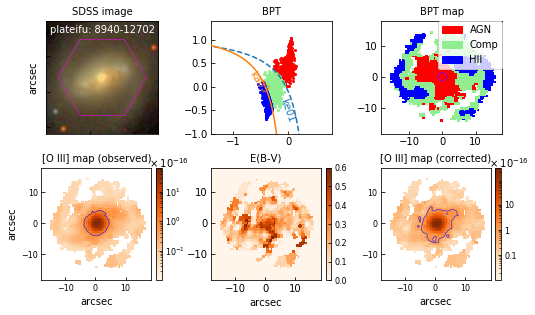

In [11]:
#Used for PPT

from mangatools.maps import Maps
from mangatools.fitmaps import FitMaps

set_matplotlib_formats('png')
fs = 10 #fontsize
las = 8 #lable size

fm_dir = '/Volumes/Lacie2/fitmaps/fitmap/' #set to your local folder
fm_binned_dir = '/Volumes/Lacie2/fitmaps/fitmap2/' #set to your local folder

fig = plt.figure(figsize=(8, 6))
ax = fig.subplots(2,3)
plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2, wspace=0.4, hspace=0.3)

if True:
    plateifu = '8940-12702'
    m = Maps(plateifu)
    fm = FitMaps(plateifu, fitmaps_dir=fm_dir, fitmaps_binned_dir=fm_binned_dir)
    
    #plt.imshow(m2.E_BV, origin='lower')

    #width = int(m.ifudsgn) // 10
    #m.image(ax=ax[i, 0], showImage=False, mini=True, fs=5)
    m.image_quary(ax=ax[0, 0], scale=0.06, width=640, height=640, show_bundle=True, lw=0.5, opt='', fs=fs)
    m.bpt(ax=ax[0, 1], showImage=False, mini=True, fs=fs)
    ax[0,1].text(-0.18, -0.4, 'ke01', rotation=-70, fontsize=fs, color='C0')
    ax[0,1].text(-0.75, 0.2, 'ka03', rotation=-55, fontsize=fs, color='C1')

    m.bpt2d(ax=ax[0, 2], show_psf=True, showImage=False, mini=True, fs=fs)
    #ax[i, 2].text(-5, 5, '19', fontsize=fs)
    #m.vfield(ax=ax[i, 2], showImage=False, mini=True, fs=2)
    #m.line('OIII-5008', plot=True, ax=ax[i, 3], showImage=False, redcorr=True, snr=3,
    #       mini=True, fs=4, showColorbar=False)
    #m.line_ew('Ha-6564', plot=True, ax=ax[i, 4], showImage=False, mini=True, fs=4, showColorbar=False)
    
    #O3, O3_err = fm.O3map(redcorr=False)
    O3data = fm.line('[OIII]5008') + fm.line('_[OIII]5008')
    O3, O3_err = O3data[0], O3data[1]
    O3_corr, O3_corr_err = fm.O3map(fix_outlier=True, smooth=False)

        #m.redcorrmap(plot=True, showImage=False, ax=ax[i,4], mini=True, fs=4, showColorbar=True)
    x, y = m.maps['SPX_SKYCOO'].data
    x = np.flip(x)
    extent = [x.min(), x.max(), y.min(), y.max()]
    
    sb_orig = 4 * O3 / 10
    im = ax[1, 0].pcolormesh(x, y, sb_orig, norm=colors.LogNorm(vmin=0.01, vmax=sb_orig.max()), cmap='Oranges')
    cs = ax[1, 0].contour(x, y, sb_orig, levels=[1], colors='b', extent=extent, linewidths=0.5)
    ax[1, 0].tick_params(axis='both', which='major', labelsize=las)
    cbar = plt.colorbar(im, ax=ax[1, 0], fraction=0.056, pad=0.04, ticks=[0.1, 1, 10], orientation='vertical')
    cbar.ax.tick_params(labelsize=las)
    cbar.ax.set_title(r'$\quad\quad\times 10^{-16}$', fontsize=fs, pad=0.2)
    
    sb = 4 * O3_corr / 10
    im = ax[1, 2].pcolormesh(x, y, sb, norm=colors.LogNorm(vmin=0.01, vmax=sb.max()), cmap='Oranges')
    cs = ax[1, 2].contour(x, y, sb, levels=[1], colors='b', extent=extent, linewidths=0.5)
    #plt.clabel(cs, inline=1, fontsize=5, fmt='%1.1f')
    cbar = plt.colorbar(im, ax=ax[1, 2], fraction=0.056, pad=0.04, ticks=[0.1, 1, 10], orientation='vertical')
    cbar.ax.tick_params(labelsize=las)
    cbar.ax.set_title(r'$\quad\quad\times 10^{-16}$', fontsize=fs, pad=0.2)
    ax[1, 2].tick_params(axis='both', which='major', labelsize=las)
    # change the tick label
    #cbar = fig.colorbar(cax, ticks=[0.1, 1, 10], orientation='horizontal')
    cbar.ax.set_yticklabels(['0.1', '1', '10'])  # horizontal colorbar
    #labels = [item.get_text() for item in cbar.get_xticklabels()]
    #labels[1] = 'Testing'
    #cbar.set_xticklabels(labels)

    E_BV = fm.E_BV
    im = ax[1, 1].pcolormesh(x, y, E_BV, vmax=0.6, cmap='Oranges')
    cbar = plt.colorbar(im, ax=ax[1, 1], fraction=0.056, pad=0.04)
    cbar.ax.tick_params(labelsize=las)
    ax[1, 1].tick_params(axis='both', which='major', labelsize=fs)
    
    ax[0, 0].set_title('SDSS image', fontsize=fs)
    ax[0, 1].set_title("BPT", fontsize=fs)
    ax[0, 2].set_title('BPT map', fontsize=fs)
    ax[1, 0].set_title('[O III] map (observed)', fontsize=fs)
    ax[1, 1].set_title("E(B-V)", fontsize=fs)
    ax[1, 2].set_title('[O III] map (corrected)', fontsize=fs)

    ax[1, 0].set_xlabel('arcsec', fontsize=fs)
    ax[0, 0].set_ylabel('arcsec', fontsize=fs)
    ax[1, 0].set_ylabel('arcsec', fontsize=fs)
    ax[1, 1].set_xlabel('arcsec', fontsize=fs)
    ax[1, 2].set_xlabel('arcsec', fontsize=fs)
    
fig.savefig("./results/L_OIII.pdf", bbox_inches='tight')

# Shapes of ENLR (deprecated)

Different morphology of ENLR
Using the Fourier series to determine it's shape, by calculate the agn fraction in every derection, and fitting it with Forier series, the different components of the fourier series stands for different period shape.(He Z. C. 2018 in prepare)
$$f(\theta_k) = a_0 + \sum^\infty_{m=1}[a_m\cos(m\theta_k+b_m\sin(m \theta_k)] $$
We divided the circle 360 degree into 36 bins, each with 10 degree, so the discret series with the parameter of each component is:
$$ a_m = \frac{2}{2\pi}\sum^{36}_{k=1}f(\theta)\cos(m\theta_k)\frac{10\pi}{180} $$
$$ b_m = \frac{2}{2\pi}\sum^{36}_{k=1}f(\theta)\sin(m\theta_k)\frac{10\pi}{180} $$
$$ a_0 = \frac{1}{36}\sum^{36}_{k=1}f(\theta) $$

## Demo-ENLR-Shapes

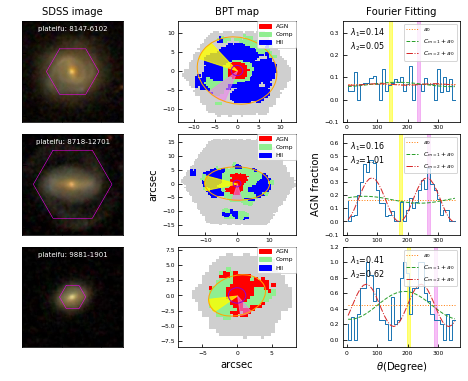

In [201]:
# demo used in the papaer
# History:
#   2018-10-23: update for PPT

set_matplotlib_formats('png')

from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection

targets = ['8147-6102', '8718-12701', '9881-1901']
fs = 10

fig = plt.figure(figsize=(8, 6))
ax0 = fig.subplots(1, 3)
for i in range(3):
    ax0[i].spines['top'].set_color(None)
    ax0[i].spines['bottom'].set_color(None)
    ax0[i].spines['left'].set_color(None)
    ax0[i].spines['right'].set_color(None)
    ax0[i].tick_params(axis='both', labelcolor='w', top=False, bottom=False, left=False, right=False, labelsize=2)
    

ax = fig.subplots(3,3)
plt.subplots_adjust(wspace=0.4, hspace=0.12)
for i in range(len(targets)):
    plateifu = targets[i]
    m = Maps(plateifu)
    m.image_quary(ax=ax[i, 0], scale=0.06, width=640, height=640, show_bundle=True, lw=0.5, opt='', fs=fs-3)
    m.bpt2d(ax=ax[i,1], mini=True, showImage=False, show_psf=True, show_Re=True, Re=m.target_range,
            fs=6, showTitle=False, show_bundle=True)
    phi = m.elpetro_phi + 90
    r1, r2 = m.eshape(plot=True, ax=ax[i,2], fs=fs-4, lw=1, ms=2, useHaEW=True)
    ax[i, 1].set_xlabel("")
    ax[i, 2].set_xlabel("")
    ax[i, 2].set_ylabel("")
    # add the sectors
    patches = [Wedge((0., -0.), m.target_range*m.elpetro_r, phi-15, phi+15),]
    p = PatchCollection(patches, alpha=0.8, color='yellow')
    ax[i, 1].add_collection(p)
    ax[i, 2].fill_betweenx([-1, 2], phi-5, phi+5, color='yellow', alpha=0.5)

    patches = [Wedge((0., -0.), m.target_range*m.elpetro_r*m.elpetro_ba, phi+90-15, phi+90+15),]
    p = PatchCollection(patches, alpha=0.6, color='violet')
    ax[i, 1].add_collection(p)
    ax[i, 2].fill_betweenx([-1, 2], phi+90-5, phi+90+5, color='violet', alpha=0.5)
    
ax[0, 0].set_title('SDSS image', fontsize=fs)
ax[0, 1].set_title('BPT map', fontsize=fs)
ax[0, 2].set_title('Fourier Fitting', fontsize=fs)
ax[2, 1].set_xlabel('arcsec', fontsize=fs)
ax[1, 1].set_ylabel('arcsec', fontsize=fs)
ax[2, 2].set_xlabel(r'$\theta$(Degree)', fontsize=fs)
ax[1, 2].set_ylabel('AGN fraction', fontsize=fs)
  
fig.savefig('./results/morphology_exmaple.pdf', bbox_inches='tight')
plt.show()
set_matplotlib_formats('png') 

In [95]:
LO3data = Table.read('data/LO3-2019-04-29.dat', format="ascii")
Rdata = Table.read('data/R_fsb(10)-2019-05-03.dat', format='ascii')

LO3 = LO3data['LO3_redcorr']
LO3_err = LO3data['LO3_redcorr_err_up']

R = Rdata['logR_fsb2_orig']
R_err = Rdata['logR_fsb2_orig_err']
is_limit = Rdata['is_limit'].data == 1
R[is_limit] = Rdata['logR_fsb1'].data[is_limit]

#mcmc_fitting = Table.read('data/mcmc.txt', format='ascii')
#is_converge = (mcmc_fitting['is_converge'] >= 1)

#LO3 = LO3[is_converge]
#LO3_err = LO3_err[is_converge]
#R = R[is_converge]
#R_err = R_err[is_converge]

# plot the ENLR shape
NLR_round = []
NLR_twoside = []
NLR_twoside_plateifu = []
NLR_oneside = []
NLR_unresolved = []
all_list = []
all_morphology = []
for i in range(len(LO3data['plateifu'])):
    #if not is_converge[i]:
    #    continue
    shape = None
    plateifu = LO3data['plateifu'][i]
    m = maps.Maps(plateifu)
    O3_i = LO3[i]
    O3_err_i = LO3_err[i]
    R_i = R[i]
    try:
        r1, r2 = m.eshape()
    except:
        print("Error when doing {}".format(plateifu))
        continue
    #print(r1, r2)
    if r2 >= 0.3:
        if r1 > r2:
            NLR_oneside.append([O3_i, R_i])
            shape = 'conical'
        else:
            NLR_twoside.append([O3_i, R_i])
            NLR_twoside_plateifu.append(plateifu)
            shape = 'bi-conical'
    elif r1 >= 0.3:
        NLR_oneside.append([O3_i, R_i])
        shape = 'conical'
    else:
        NLR_round.append([O3_i, R_i])
        shape = 'round'
    all_list.append([r1, r2])
    all_morphology.append(shape)

In [96]:
len(NLR_twoside_plateifu)

69

In [192]:
import matplotlib.backends.backend_pdf as mpdf
from matplotlib.patches import Wedge
from matplotlib.collections import PatchCollection
from matplotlib import colors
import matplotlib.patches as mpatches


save = True
fs = 8

if save:
    plt.ioff() #turnoff the inline plot, just save them to file
    pdf = mpdf.PdfPages('results/shape-checking2-{}.pdf'.format(today))
    i=0

targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')
tot_num = len(targets[:4])

for i in range(tot_num):
    plateifu = targets['plateifu'][i]
    m = Maps(plateifu)
    fig, ax = plt.subplots(1,3, figsize=(8, 3))
    m.image_quary(ax=ax[0], scale=0.06, width=640, height=640, show_bundle=True, lw=0.5, opt='', fs=fs-3)
    
    # traditional BPT
    m.bpt2d(ax=ax[1], mini=True, showImage=False, show_psf=True, show_Re=True, Re=m.target_range,
            fs=6, showTitle=False, show_bundle=False)
    
    r1, r2 = m.eshape(plot=True, ax=ax[2], fs=fs-4, lw=1, ms=2)
    # add the sectors
    phi = m.elpetro_phi - 90
    patches = [Wedge((0., -0.), m.target_range*m.elpetro_r, phi-15, phi+15),]
    p = PatchCollection(patches, alpha=0.8, color='yellow')
    #colors = 100*np.random.rand(len(patches))
    #p.set_array()
    ax[1].add_collection(p)

    plt.subplots_adjust(left=0.05, right=0.95, top=0.8, bottom=0.2)
    if save:
        pdf.savefig(fig)
    plt.close()
        #utils.processBar(tot_num-1, i)
if save:
    pdf.close()
    %matplotlib inline
    print("Done! Plot into results/shape-checking2-{}.pdf".format(today))


Done! Plot into results/shape-checking2-2019-06-16.pdf


In [196]:
# checking Ha EW effects
targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')
tot_num = len(targets[:4])

save = True
fs = 8

if save:
    plt.ioff() #turnoff the inline plot, just save them to file
    pdf = mpdf.PdfPages('results/AGN-ewHa-{}.pdf'.format(today))
    i=0

targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')
tot_num = len(targets[:])

for i in range(tot_num):
    plateifu = targets['plateifu'][i]
    m = Maps(plateifu)
    fig, ax = plt.subplots(1,3, figsize=(8, 3))
    m.image_quary(ax=ax[0], scale=0.06, width=640, height=640, show_bundle=True, lw=0.5, opt='', fs=fs-3)
    
    # traditional BPT
    m.bpt2d(ax=ax[1], mini=True, showImage=False, show_psf=True, show_Re=True, Re=m.target_range,
            fs=6, showTitle=False, show_bundle=False)
    if True:
        agn, cp, *others = m.bptregion()
        x_coor, y_coor = m.maps['SPX_SKYCOO'].data
        ewHa_region = m.line_ew('Ha-6564') > 3
        region_color = ['red','lightgreen','blue'] 
        region_name = ['AGN', 'Comp', 'HII']
        bounds = [0.5, 1.5, 2.5, 3.5] # set color for imshow
        cmap = colors.ListedColormap(region_color)
        norm = colors.BoundaryNorm(bounds, cmap.N)
        # the map data was up-down inverse as the optical image from sdss
        agn_region = np.ma.array(np.full_like(agn, 1), mask=~(agn & ewHa_region))
        ax[2].pcolormesh(x_coor, y_coor, agn_region, cmap=cmap, norm=norm)
        
    plt.subplots_adjust(left=0.05, right=0.95, top=0.8, bottom=0.2)
    if save:
        pdf.savefig(fig)
    plt.close()
        #utils.processBar(tot_num-1, i)
if save:
    pdf.close()
    %matplotlib inline
    print("Done! Plot into results/AGN-ewHa-{}.pdf".format(today))

Done! Plot into results/AGN-ewHa-2019-06-16.pdf


In [173]:
plateifu = '8718-12701'
m = Maps(plateifu)
            
xx = (np.arange(m.naxis1) - m.naxis1 * 0.5) * 0.5
yy = (np.arange(m.naxis2) - m.naxis2 * 0.5) * 0.5
x_coor, y_coor = np.meshgrid(xx, yy)
r, rr, phi = m.maps['SPX_ELLCOO'].data
agn, cp, *other = m.bptregion()

phi_list =[]
frac_list = []
lw = 2
fs = 6



for i in range(36):
    pa = i*10

    section_bin = utils.sector_binning(r, phi, r_min=0, r_max=m.target_range*m.elpetro_r, 
                                       phi_min=pa-5, phi_max=pa+5)
    section_bin = np.ma.array(np.full_like(section_bin, 1), mask=~section_bin)
    
    total_pixel = np.sum((m.maps['BINID'].data[0]>0) & section_bin)
    if total_pixel == 0:
        frac = 0
    else:
        frac = np.sum(agn & section_bin)/total_pixel
                
    frac_list.append(frac)
    phi_list.append(pa-5)
    
    
    fig = plt.figure(figsize=(6, 2))
    ax = fig.subplots(1,2)
    plt.subplots_adjust(wspace=0.4, hspace=0.12)
    plt.ioff()
    plt.suptitle(r'$\theta={}^o$'.format(pa))

    
    #m.image_quary(ax=ax[0], scale=0.06, width=640, height=640, show_bundle=True, lw=0.5, opt='', fs=fs-3)
    m.bpt2d(ax=ax[0], mini=True, showImage=False, show_psf=True, show_Re=True, Re=m.target_range,
            fs=6, showTitle=False, show_bundle=False)
    ax[0].pcolormesh(x_coor, y_coor, section_bin, alpha=0.8)
    
    ax[1].step(phi_list, frac_list)
    ax[1].set_xlabel('theta', fontsize=fs)
    ax[1].set_ylabel('fraction', fontsize=fs)
    ax[1].set_xlim(0, 360)
    ax[1].set_ylim(-0.1, 0.5)

    fig.savefig('results/shape/shape-{:0>2d}.png'.format(i), dpi=200, bbox_inches='tight')
    plt.close()

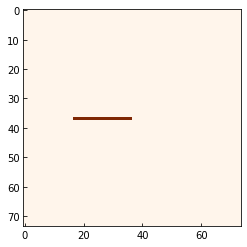

In [160]:
plt.imshow(section_bin)

# Testing L[O III] between MaNGA and SDSS

In [236]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.cosmology import LambdaCDM

cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
H0 = 70*u.km/u.s/u.Mpc

In [237]:
# get redshift
from mangatools.manga import MaNGA
targets = Table.read('data/AGNs-2019-04-26.dat', format='ascii')

z_list = []
for plateifu in targets['plateifu']:
    g = MaNGA(plateifu)
    z_list.append(g.z)
print(z_list)

[0.0318073, 0.0806967, 0.0282021, 0.0266298, 0.129403, 0.0244671, 0.131997, 0.0312591, 0.126168, 0.12611, 0.0268253, 0.0607597, 0.030345, 0.0378229, 0.0257723, 0.0582143, 0.0602584, 0.0420468, 0.0558079, 0.0283402, 0.12226, 0.0247632, 0.12908, 0.125582, 0.0275673, 0.0298414, 0.0633343, 0.0321959, 0.0291196, 0.119399, 0.0311758, 0.0343116, 0.030363, 0.0267882, 0.0473019, 0.0631476, 0.0636542, 0.035737, 0.038928, 0.04992, 0.049053, 0.0261046, 0.0543641, 0.0584258, 0.0665263, 0.0372518, 0.0227214, 0.0448811, 0.0286035, 0.0263847, 0.0303346, 0.0346392, 0.0724271, 0.0532814, 0.0473068, 0.045503, 0.0358627, 0.0314197, 0.131457, 0.0547198, 0.0429606, 0.034659, 0.0470053, 0.0431534, 0.0482447, 0.0386619, 0.026913, 0.0227967, 0.0657771, 0.0136253, 0.0267379, 0.0233453, 0.0294089, 0.0264158, 0.0323135, 0.053819, 0.026442, 0.0268301, 0.0253738, 0.0263526, 0.067572, 0.0181814, 0.0281762, 0.0808831, 0.0287366, 0.0601609, 0.0228872, 0.0866, 0.0286559, 0.0469711, 0.0470113, 0.037232, 0.0296172, 0.023

In [238]:
manga_coor = SkyCoord(ra=targets['ra']*u.degree, dec=targets['dec']*u.degree, 
                     distance=(const.c*z_list/H0).to(u.kpc))

In [19]:
targets

plateifu,ra,dec,mangaid,BPT_x,BPT_y,EW_Ha,is_limit,edge_on
str10,float64,float64,str9,float64,float64,float64,int64,float64
7495-1902,205.044768573,26.8410410581,12-129608,-0.49598774313926697,0.6899823546409607,4.434834957122803,0,0.5
7815-6104,319.193098655,11.0437407875,1-113712,-0.027410242706537247,0.9426983594894409,67.97575378417969,0,0.0
7991-6104,258.82741019,57.6587701679,1-24148,0.24625034630298615,0.9930230975151062,6.368241786956787,0,0.5
7991-3702,258.158751804,57.3224214281,1-23979,-0.1977314054965973,0.48275935649871826,7.548041820526123,0,0.0
8132-6101,111.733682055,41.0266910782,1-548024,0.01209196075797081,0.46090805530548096,9.873613357543945,0,0.0
8247-6101,136.089598316,41.4817290009,1-217022,-0.07965685427188873,0.15799376368522644,4.21174430847168,0,0.0
8137-3702,115.368719754,44.4087940076,1-574402,0.08911055326461792,0.7996183037757874,15.94538402557373,0,0.0
8141-1901,117.472421015,45.2484834965,1-339094,-0.10372020304203033,0.7885287404060364,7.816201686859131,0,0.0
8256-12704,166.129407835,42.6245544187,1-558912,0.04632899910211563,0.7491806745529175,19.344974517822266,0,0.0


In [239]:
# MPA DR7
from astropy.table import Table

database_dir = '/Volumes/Lacie2/other/'
dr7_info_file = database_dir + 'gal_info_dr7_v5_2.fit'
dr7_line_file = database_dir + 'gal_line_dr7_v5_2.fit'
dr7_iclass_file = database_dir + 'gal_iclass_table_dr7_v5_2.fits'
dr7info = Table.read(dr7_info_file)
dr7line = Table.read(dr7_line_file)
dr7iclass = Table.read(dr7_iclass_file)


In [240]:
#valid_coor = (dr7info['RA'] > -999.) & (dr7info['DEC'] > -999.) \
#             & (dr7info['TARGETTYPE'].strip() == 'GALAXY' | dr7info['TARGETTYPE'].strip == 'QSO')
valid_coor = (dr7info['DEC'] <= 90.) & (dr7info['DEC']>=-90.) & (dr7info['Z']>0)
dr7_valid = dr7info[valid_coor]
dr7_line_valid = dr7line[valid_coor]


dr7_coor = SkyCoord(ra=dr7_valid['RA']*u.degree, dec=dr7_valid['DEC']*u.degree, 
                   distance=(const.c*dr7_valid['Z']/H0).to(u.kpc))

In [ ]:
idx, d2d, d3d = manga_coor.match_to_catalog_3d(dr7_coor)
#idx, d2d, d3d = mpl6_coor.match_to_catalog_sky(dr7_coor)

In [244]:
d2d[2] < 2*u.arcsec

True

In [245]:
len(idx)

152

In [246]:
valid = d2d < 2*u.arcsec
idx2 = idx[valid]
sdss_manga_info = dr7_valid[idx2]
sdss_manga_line = dr7_line_valid[idx2]

In [247]:
targets_OIII = Table.read('data/LO3-2019-06-25.dat', format='ascii')
targets_OIII[:2]

plateifu,LO3,LO3_err_low,LO3_err_up,LO3_redcorr,LO3_redcorr_err_low,LO3_redcorr_err_up,outflow_strength,outflow_strength_err
str11,float64,float64,float64,float64,float64,float64,float64,float64
7495-1902,39.53623161431995,0.0010603917243580511,0.001267280212862513,39.65635120069981,0.09374249904269233,0.491424517264807,0.0008645596752389612,0.0006841116416902532
7815-6104,42.50973134777506,7.344580260656296e-05,7.510125187296896e-05,42.61506259911391,0.01732007700436971,0.48294102174753645,0.2109876083165601,0.0001564459240877599


In [72]:
list(targets[4:8]['plateifu'])


['8132-6101', '8247-6101', '8137-3702', '8141-1901']

In [248]:
sdss_manga_info[:2]

PLATEID,MJD,FIBERID,PHOTOID [5],RA,DEC,PLUG_MAG [5],PRIMTARGET,SECTARGET,TARGETTYPE,SPECTROTYPE,SUBCLASS,Z,Z_ERR,Z_WARNING,V_DISP,V_DISP_ERR,SN_MEDIAN,E_BV_SFD,ZTWEAK,ZTWEAK_ERR,SPECTRO_MAG [3],KCOR_MAG [3],KCOR_MODEL_MAG [5],RELEASE
int16,int32,int16,int16,float32,float32,float32,int16,int16,bytes19,bytes6,bytes21,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes12
2246,53767,374,4670 .. 94,205.04478,26.84103,20.3408 .. 17.2615,64,0,GALAXY,GALAXY,,0.031807315,1.4146918e-05,0,47.360046,7.0862393,22.956573,0.009059035,0.0,0.0,18.365953 .. 17.152395,18.323278 .. 17.1566,0.0 .. 0.0,dr6
355,51788,500,1336 .. 156,258.8274,57.658783,19.5471 .. 15.961,96,0,GALAXY,GALAXY,AGN,0.028202085,7.5992343e-06,0,130.66539,3.6488123,37.674053,0.04191593,0.0,0.0,17.36544 .. 16.03051,17.313967 .. 16.030882,0.0 .. 0.0,dr123


Text(0, 0.5, 'L$_{\\rm [O III]}$ MaNGA')

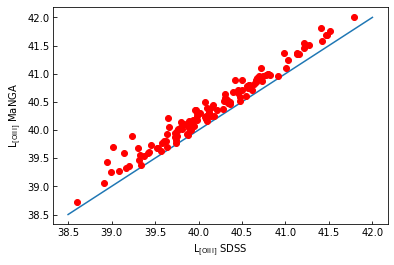

In [251]:
LO3_manga = targets_OIII['LO3'][valid]
sdss_d = cosmo.luminosity_distance(sdss_manga_info['Z'])

LO3_sdss = np.log10(sdss_manga_line['OIII_5007_FLUX'] * 1e-17/u.cm**2*4*np.pi*(sdss_d**2).to(u.cm**2))

xx = np.linspace(38.5, 42, 100)
yy = xx
plt.plot(xx, yy)
plt.plot(LO3_sdss, LO3_manga, 'ro')
plt.xlabel(r'L$_{\rm [O III]}$ SDSS')
plt.ylabel(r'L$_{\rm [O III]}$ MaNGA')